In [1]:
%load_ext autoreload

In [2]:
%autoreload

import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import corner
import jx.hmc as hmc
import numpy as np

In [3]:
beta0_mean = 1.2
beta1_mean = 2.3
beta0_sigma = 0.1
beta1_sigma = 0.5
sigma = 1.7
k = 10
n = 100

beta0_arr = np.random.normal(beta0_mean, beta0_sigma, size=k).reshape(-1, 1)
beta1_arr = np.random.normal(beta1_mean, beta1_sigma, size=k).reshape(-1, 1)
sigma_arr = np.random.exponential(sigma, size=k).reshape(-1, 1)
x = np.random.uniform(0, 10, size=(k, n))
ymean = beta0_arr + beta1_arr * x
y = np.random.normal(ymean, sigma_arr)

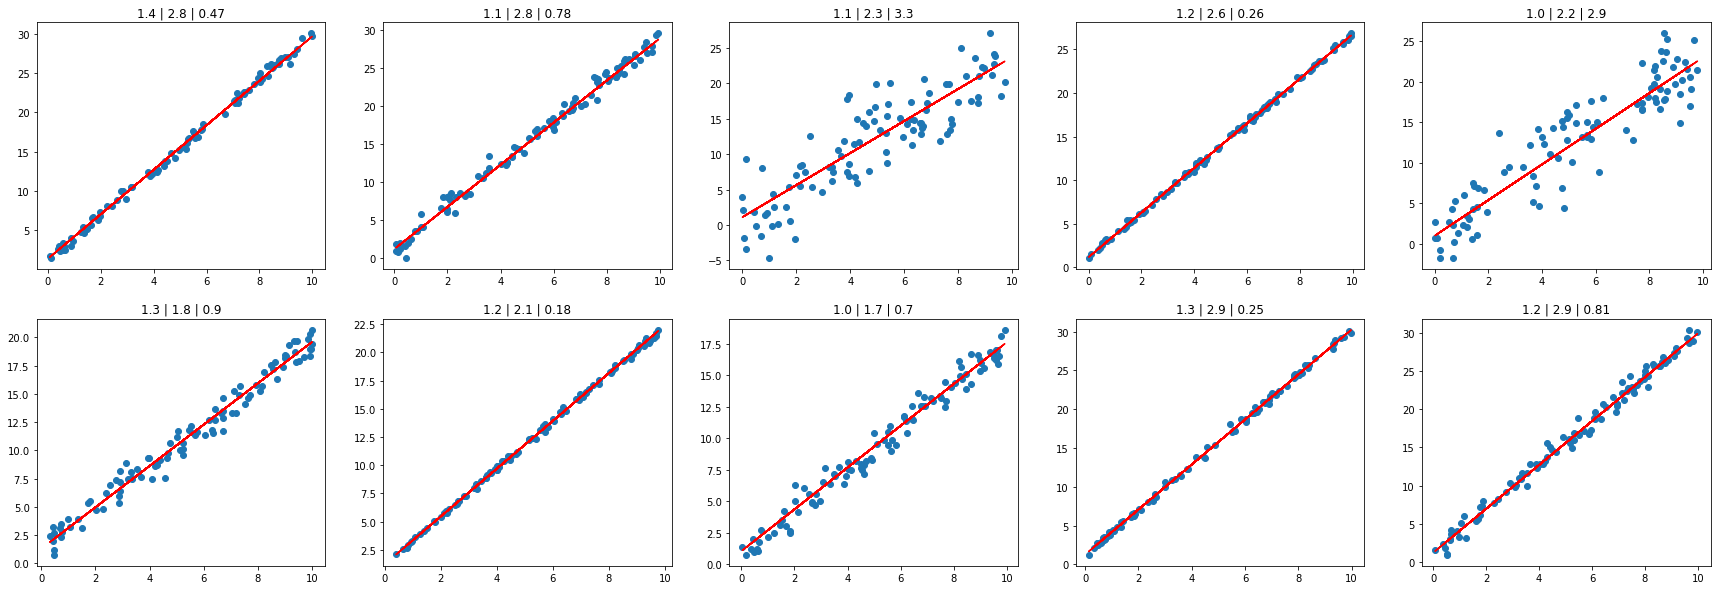

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10))

for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        ax[i,j].scatter(x[idx], y[idx])
        ax[i,j].plot(x[idx], ymean[idx], c='r')
        ax[i,j].set_title(f"{beta0_arr[idx][0]:.2} | {beta1_arr[idx][0]:.2} | {sigma_arr[idx][0]:.2}")

In [5]:
def ln_hyperprior(params):
    beta0_mean, beta0_sigma, beta1_mean, beta1_sigma, sigma_scale, _, _, _ = params
    target = 0
    target += stats.norm.logpdf(beta0_mean)
    target += stats.expon.logpdf(jnp.exp(beta0_sigma))
    target += stats.norm.logpdf(beta1_mean)
    target += stats.expon.logpdf(jnp.exp(beta1_sigma))
    target += stats.expon.logpdf(jnp.exp(sigma_scale))
    return target
    
def ln_prior(params):
    beta0_mean, beta0_sigma, beta1_mean, beta1_sigma, sigma_scale, beta0_arr, beta1_arr, sigma_arr = params
    target = 0
    target += stats.norm.logpdf(beta0_arr, beta0_mean, jnp.exp(beta0_sigma)).sum()
    target += stats.norm.logpdf(beta1_arr, beta1_mean, jnp.exp(beta1_sigma)).sum()
    target += stats.expon.logpdf(jnp.exp(sigma_arr), scale=jnp.exp(sigma_scale)).sum()
    return target.sum()

def ln_likelihood(params, data):
    _, _, _, _, _, beta0_arr, beta1_arr, sigma_arr = params
    x, y = data[:,0], data[:,1]
    return stats.norm.logpdf(y, beta0_arr + beta1_arr * x, jnp.exp(sigma_arr)).sum()

def ln_posterior(params, data):
    return ln_hyperprior(params) + ln_prior(params) + ln_likelihood(params, data)

@jax.jit
def ln_unnormalized_posterior(params):
    return ln_posterior(params, jnp.stack((x, y)).T)

In [6]:
k = jax.random.PRNGKey(0)
samples, momentum, paccepts, mle = hmc.sample(ln_unnormalized_posterior, 1000, 10, 5e-3, 1000, 0.1, 8, 500, k)

100%|████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.03it/s]


In [ ]:
plt.plot(samples[:,0])
plt.plot(samples[:,1])
plt.plot(jnp.exp(samples[:,2]))

In [ ]:
corner.corner(np.array(samples), truths=(beta0, beta1, jnp.log(sigma)));

In [ ]:
corner.corner(np.array(momentum), truths=np.zeros(3));